# Imports

In [5]:
import sys
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import flopy
from flopy.mf6.utils import Mf6Splitter

# print some inf
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.11.9 (main, Apr  2 2024, 13:43:44) [GCC 13.2.0]
numpy version: 1.26.3
matplotlib version: 3.9.2
flopy version: 3.9.2


# Paths and Simulation

In [12]:
# define paths and 
model_dir = "./model" 
sim_name = "mfsim.nam"
exe_name = "mf6"
output_dir = "./submodels"

# load the simulation
try:
    print(f"loading simulation from {model_dir}/{sim_name}...")
    base_sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, sim_ws=model_dir, exe_name=exe_name)
    base_gwf = base_sim.get_model()
    print("simulation loaded successfully")
except Exception as e:
    sys.exit(f"error loading simulation: {e}")


loading simulation from ./model/mfsim.nam...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package ghb...
    loading package npf...
    loading package sto...
    loading package hfb...
    loading package wel...
  loading solution package rgtihm...
simulation loaded successfully


# Model Splitting
Split the model and write simulation

In [19]:
# define splitting settings
n_submodels = 4 # number of parts to split into (works with 2; adjust as needed)
use_metis = True  # using METIS
output_dir = "./submodels"

# create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

# initialize splitter
mfsplit = Mf6Splitter(base_sim)

# print basic DIS info
print("model DIS info:")
print(f" - layers: {base_gwf.dis.nlay.array}")
print(f" - rows: {base_gwf.dis.nrow.array}")
print(f" - columns: {base_gwf.dis.ncol.array}")

# attempt splitting with METIS
try:
    print(f"using METIS to split into {n_submodels} parts")
    split_array = mfsplit.optimize_splitting_mask(nparts=n_submodels)
    # ensure integer array
    if not np.issubdtype(split_array.dtype, np.integer):
        split_array = split_array.astype(int)

except Exception as e:
    print(f"error in METIS splitting: {e}")
    sys.exit("splitting failed; check METIS support or adjust n_submodels")

# split the model
try:
    new_sim = mfsplit.split_model(split_array)
except Exception as e:
    sys.exit(f"error splitting model: {e}")

# set output path and write simulation
shutil.rmtree(output_dir, ignore_errors=True)
new_sim.set_sim_path(output_dir)
new_sim.write_simulation(silent=True)

# report results
model_names = list(new_sim.model_names)
print(f"created {len(model_names)} submodels: {model_names}")
print(f"split models saved in: {output_dir}")

model DIS info:
 - layers: 9
 - rows: 912
 - columns: 328
using METIS to split into 4 parts
created 4 submodels: ['rgtihm_0', 'rgtihm_1', 'rgtihm_2', 'rgtihm_3']
split models saved in: ./splitmodels


# Visualize split models

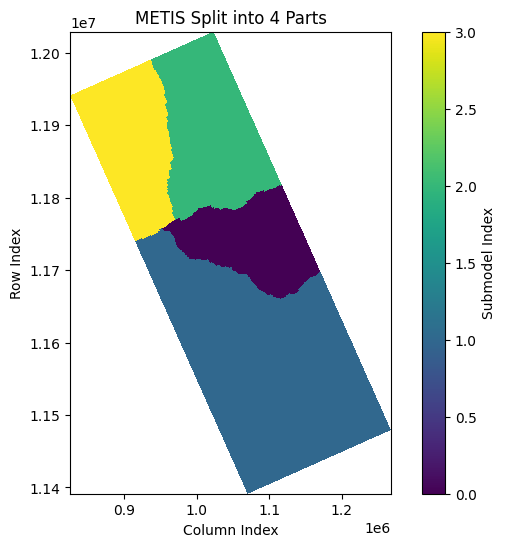

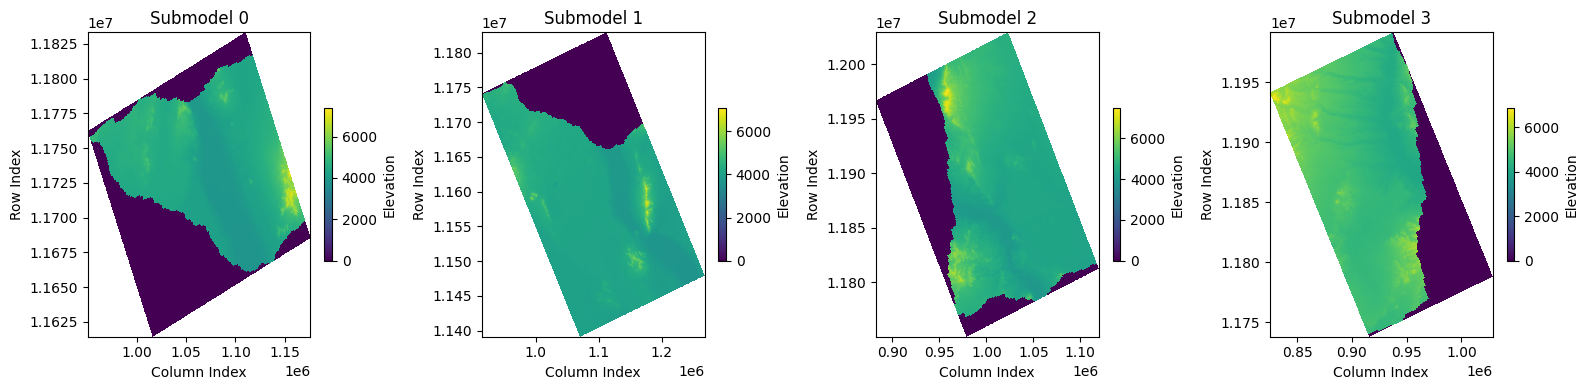

In [25]:
# number of submodels (for title and layout purposes)
n_submodels = len(model_names)

# plot all submodels in one image (split array)
plt.figure(figsize=(8, 6))
pmv = flopy.plot.PlotMapView(model=base_gwf)
pa = pmv.plot_array(split_array, cmap="viridis")
plt.colorbar(pa, label="Submodel Index")
plt.title(f"METIS Split into {n_submodels} Parts")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

# reconstruct split model top elevation for each submodel
val_dict = {}
for modelname in model_names:
    mnum = int(modelname.split("_")[-1])
    val_dict[mnum] = new_sim.get_model(modelname).dis.top.array

# plot each submodel in a separate map using its own grid
n_cols = min(4, n_submodels)  # max 4 columns
n_rows = (n_submodels + n_cols - 1) // n_cols  # calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# flatten axes for easy iteration (works for any n_submodels)
axes_flat = axes.flatten() if n_submodels > 1 else [axes]

for i, modelname in enumerate(model_names):
    mnum = int(modelname.split("_")[-1])
    ax = axes_flat[i]
    # use the submodel's grid instead of base_gwf
    submodel = new_sim.get_model(modelname)
    pmv = flopy.plot.PlotMapView(model=submodel, ax=ax)
    pa = pmv.plot_array(val_dict[mnum], cmap="viridis")
    plt.colorbar(pa, ax=ax, shrink=0.5, label="Elevation")
    ax.set_title(f"Submodel {mnum}")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")

# hide unused subplots if n_submodels < n_rows * n_cols
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

## I ran the models locally using the following shell command;

`mpiexec -np 4 ~/usr/local/src/mf6/bin/mf6 -p`